<img src="../img/Logo.png" width="300">

# Ejercicio
## Aprendizaje de imágenes - Ejercicio de Clasificación

In [5]:
#pip install tensorflow-datasets

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Clasificación de Imágenes: Gatos vs. Perros
En este ejercicio, construiremos una red neuronal convolucional desde cero que pueda distinguir entre perros y gatos. Seguiremos estos pasos:

1. Explorar los datos de ejemplo
2. Construir una pequeña red convolucional para resolver nuestro problema de clasificación
3. Evaluar la precisión en el entrenamiento y la validación
4. Usar Data Augmentation para reducir el sobreajuste (overfitting)
5. Agregar Dropout para reducir aún más el sobreajuste


## Descrubrimos los datos

Comencemos descargando nuestros datos de ejemplo, un archivo .zip con 2,000 imágenes JPG de gatos y perros, y extrayéndolo localmente en `/tmp`.

**NOTE:** Las 2,000 imágenes utilizadas en este ejercicio son un extracto del conjunto de datos de ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) disponible en Kaggle, que contiene 25,000 imágenes. Aquí usamos un subconjunto del conjunto completo para reducir el tiempo de entrenamiento con fines educativos.

In [7]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

zsh:1: command not found: wget


In [8]:
import os
import requests
import zipfile

# URL of the dataset. Usaremos una API para conectarnos al dataset
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_path = "/tmp/cats_and_dogs_filtered.zip"
extract_path = "/tmp/cats_and_dogs_filtered"

# Descarguemos el dataset
response = requests.get(url)
with open(zip_path, 'wb') as file:
    file.write(response.content)

# Exctracción del dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to {extract_path}")

Dataset extracted to /tmp/cats_and_dogs_filtered


In [9]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

El contenido del archivo .zip se extrae en el directorio base `/tmp/cats_and_dogs_filtered`, que contiene los subdirectorios `train` y `validation` para los conjuntos de entrenamiento y validación (Consulta el [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) para repasar los conceptos de entrenamiento, validación y prueba). A su vez, cada uno de estos subdirectorios contiene las carpetas `cats` y `dogs`. Definamos cada uno de estos directorios:

In [10]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directorio con las imagenes de los gatos del train set
train_cats_dir = os.path.join(train_dir, 'cats')

# Directorio con las imagenes de los perros del train set
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directorio con las imagenes de los gatos del validation set
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directorio con las imagenes de los perros del validation set
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Ahora, veamos cómo son los nombres de los archivos en los directorios`cats` y `dogs` dentro de los directorios del `train` directories (las convenciones de nombres de archivos son las mismas en el directorio `validation`):

In [11]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.952.jpg', 'cat.946.jpg', 'cat.6.jpg', 'cat.749.jpg', 'cat.991.jpg', 'cat.985.jpg', 'cat.775.jpg', 'cat.761.jpg', 'cat.588.jpg', 'cat.239.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Vamos a averiguar el número total de imágenes de gatos y perros en los directorios  `train` y `validation`:

In [12]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


Para ambos, gatos y perros, tenemos 1,000 imágenes de entrenamiento y 500 imágenes de validación.

Ahora, echemos un vistazo a algunas imágenes para comprender mejor cómo son los conjuntos de datos de gatos y perros. Primero, configuremos los parámetros de Matplotlib:

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parametros para nuestro grafico; Representeremos las imagenes en una configuración 4x4 
nrows = 4
ncols = 4

# Índice para iterar sobre las imágenes.
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

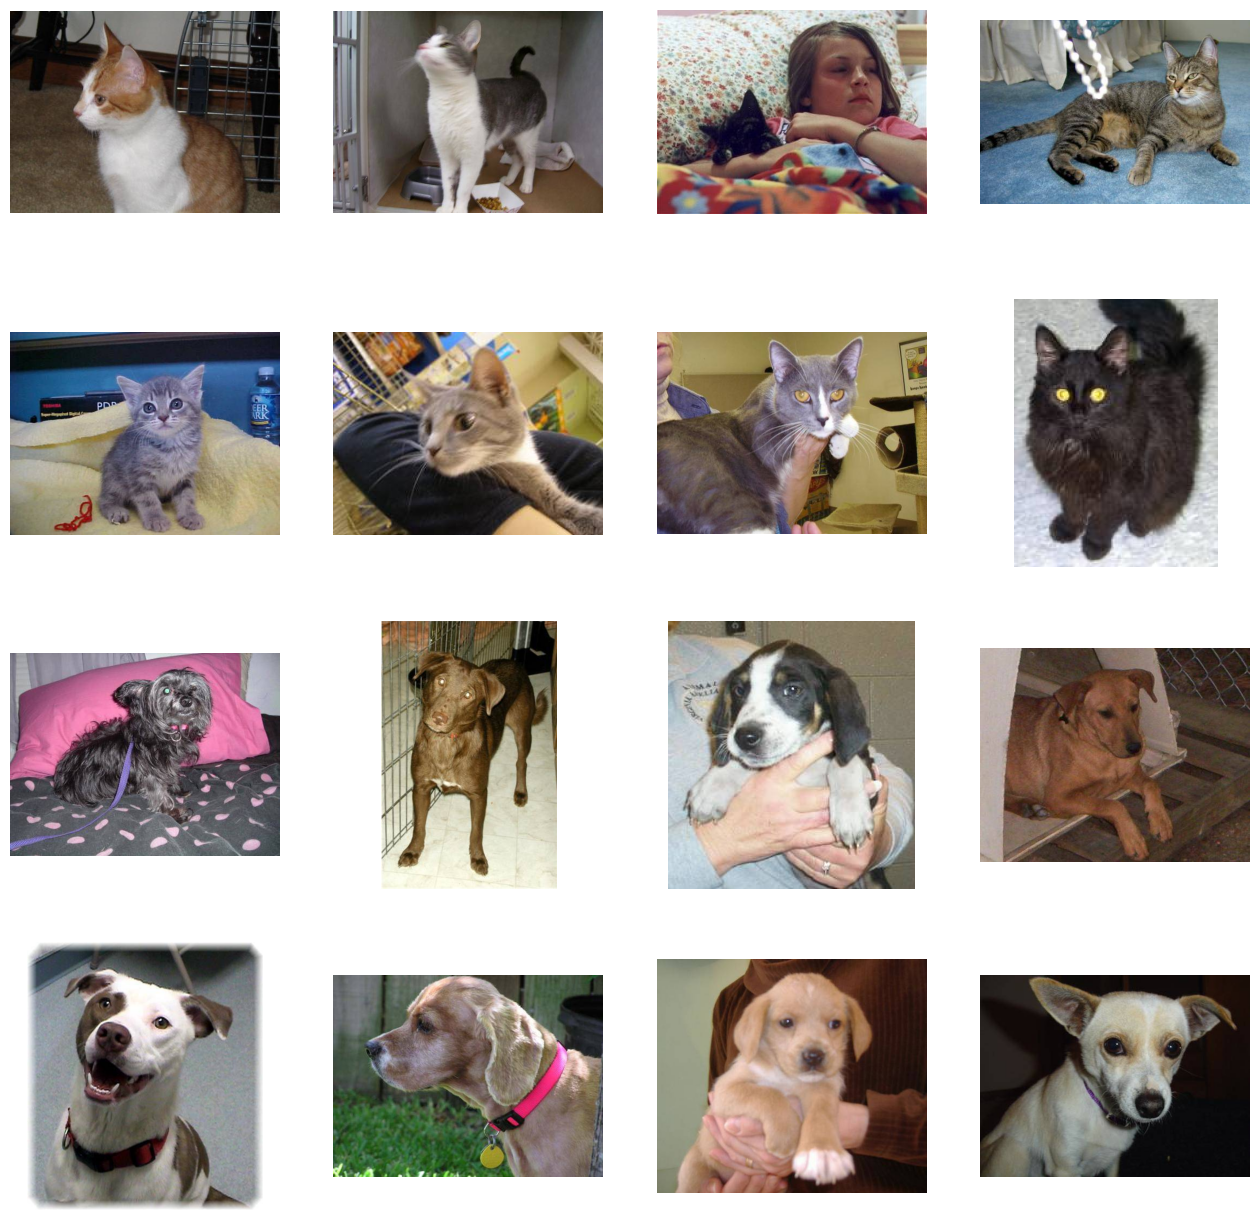

In [14]:
# Configuración de la figura de Matplotlib y ajusta su tamaño para mostrar 4x4 imágenes.
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Sin ejes ni líneas de cuadrícula (gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [15]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


32
tf.Tensor(0, shape=(), dtype=int32)


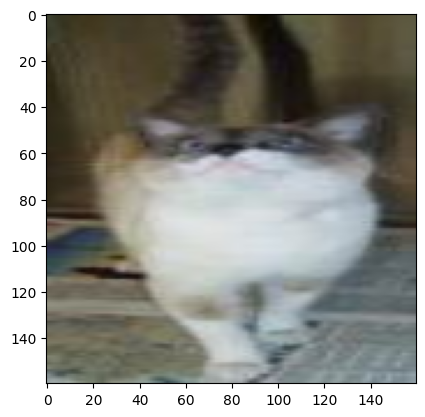

2025-02-16 20:26:03.062235: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
for element in train_dataset.take(1):
  #print(element)
  size_batch = element[0].shape[0]
  print(size_batch)
  image = element[0][0] # Imagen del primer elemento del lote (batch) de tamaño 32.
  label = element[1][0] # Etiqueta del primer elemento del lote(batch) de tamaño 32.
  print(label)
  image = image / 255.0
  plt.imshow(image)
  plt.show()

## Construcción de una Pequeña Red Convolucional desde Cero

Las imágenes que se introducirán en nuestra red convolucional son imágenes en color de 150x150 píxeles (en la próxima sección sobre Preprocesamiento de Datos, agregaremos un procedimiento para redimensionar todas las imágenes a 150x150 antes de ingresarlas en la red neuronal).

Vamos a codificar la arquitectura. Apilaremos 3 módulos de {convolución + ReLU + maxpooling}.

Nuestras capas convolucionales operarán con ventanas de 3x3.
Nuestras capas de maxpooling operarán con ventanas de 2x2.
La primera convolución extraerá 16 filtros, la segunda extraerá 32 filtros y la última extraerá 64 filtros.

**NOTA**: Esta configuración es ampliamente utilizada y se sabe que funciona bien para la clasificación de imágenes. Además, dado que tenemos relativamente pocos ejemplos de entrenamiento (1,000), usar solo tres módulos convolucionales mantiene el modelo pequeño, lo que reduce el riesgo de sobreajuste (exploraremos este tema en mayor profundidad en la segunda parte de este cuaderno).

Encima de la estructura convolucional, añadiremos dos capas completamente conectadas (fully-connected). Dado que estamos abordando un problema de clasificación binaria (dos clases), podríamos finalizar nuestra red con una activación[*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function). En ese caso, la salida de la red sería un único valor escalar entre 0 y 1, que representaría la probabilidad de que la imagen actual pertenezca a la clase 1 (en lugar de la clase 0).

Sin embargo, para hacer nuestro modelo más generalizable a problemas de clasificación con N clases, utilizaremos dos unidades de salida con una activación softmax.

In [ ]:
IMG_SIZE_HEIGHT = 160
IMG_SIZE_WIDTH = 160

cnn = tf.keras.Sequential([
    # Nuestro mapa de características de entrada es de 160x160x3:, y 3 representa los canales de color (Rojo Verde Blue).
    layers.Input(shape=(IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, 3,)),

    layers.Rescaling(1./255),

    # La primera convolución extrae 16 filtros de tamaño 3x3.
    # La convolución es seguida por una capa de max-pooling con una ventana de 2x2.
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(2),

    # TODO 1: Crear la segunda capa de convolución seguida de una capa MaxPooling2D  
    # - La segunda convolución extrae 32 filtros de tamaño 3x3.  
    # - La convolución es seguida por una capa de max-pooling con una ventana de 2x2.  



    # TODO 1.1) La tercera convolución extrae 64 filtros de tamaño 3x3.
    # La convolución es seguida por una capa de max-pooling con una ventana de 2x2.


    # TODO 2: Aplanar (Flatten) la salida de la capa precedente.
    # Aplanar el mapa de características (Feature Map) a un tensor unidimensional para poder agregar capas completamente conectadas (fully connected).



    # TODO 3: Crear la capa completamente conectada (Dense).
    # Crear una capa completamente conectada (Dense) con 512 unidades ocultas y activación ReLU.

 
    # TODO 4: Crear la capa de salida (output layer) con una única neurona y activación sigmoide.

])

Resumamos la arquitectura del modelo:

In [18]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 158, 158, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,641,954 (40.60 MB)

 Trainable params: 10,641,954 (40.60 MB)

 Non-trainable params: 0 (0.00 B)

La columna "output shape" muestra cómo evoluciona el tamaño del mapa de características en cada capa sucesiva.

Las capas de convolución reducen ligeramente el tamaño del mapa de características debido al padding. 
Cada capa de max-pooling reduce a la mitad el tamaño del mapa de características.

A continuación, configuraremos las especificaciones para el entrenamiento del modelo (model training).

Entreneremos nuestro  modelo con la función de perdida `sparse_categorial_crossentropy` ,, ya que empleamos softmax y las etiquetas están representadas como enteros en lugar de vectores one-hot. Utilizaremos el optimizador `rmsprop`  con una tasa de aprendizaje de `0.001`. Durante el entrenamiento, supervisaremos la precisión de clasificación (accuracy).

**NOTA**: En este caso usaremos como algoritmo de optimización el [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) que se prefiere comparado al [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), porque RMSprop automatiza el ajuste de la tasa de aprendizaje (learning-rate) por nosotros. (Otros algoritmos de optimización, como el [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) y [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), también adaptan automáticamente la tasa de aprendizaje durante el entrenamiento y funcionaría igualmente bien en este caso.)

In [19]:
from tensorflow.keras.optimizers import RMSprop

cnn.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

## ¡Ahora entrenemos el modelo para ver cómo funciona!

In [20]:
history = cnn.fit(train_dataset, epochs=15, validation_data=validation_dataset, verbose=2)

Epoch 1/15
63/63 - 9s - 142ms/step - acc: 0.5325 - loss: 0.9000 - val_acc: 0.5040 - val_loss: 0.6849
Epoch 2/15
63/63 - 7s - 117ms/step - acc: 0.5965 - loss: 0.6861 - val_acc: 0.5320 - val_loss: 0.6722
Epoch 3/15
63/63 - 7s - 111ms/step - acc: 0.6595 - loss: 0.6494 - val_acc: 0.6800 - val_loss: 0.6168
Epoch 4/15
63/63 - 7s - 114ms/step - acc: 0.7045 - loss: 0.5738 - val_acc: 0.5220 - val_loss: 1.0053
Epoch 5/15
63/63 - 7s - 111ms/step - acc: 0.7405 - loss: 0.5411 - val_acc: 0.7120 - val_loss: 0.5834
Epoch 6/15
63/63 - 7s - 115ms/step - acc: 0.7710 - loss: 0.4778 - val_acc: 0.7180 - val_loss: 0.5534
Epoch 7/15
63/63 - 7s - 112ms/step - acc: 0.8130 - loss: 0.4000 - val_acc: 0.7100 - val_loss: 0.5907
Epoch 8/15
63/63 - 7s - 115ms/step - acc: 0.8475 - loss: 0.3447 - val_acc: 0.7070 - val_loss: 0.6426
Epoch 9/15
63/63 - 7s - 113ms/step - acc: 0.8945 - loss: 0.2588 - val_acc: 0.7210 - val_loss: 0.6579
Epoch 10/15
63/63 - 7s - 115ms/step - acc: 0.9220 - loss: 0.1869 - val_acc: 0.6650 - val_lo

## Evaluating Accuracy and Loss for the Model

Let's plot the training/validation accuracy and loss as collected during training:

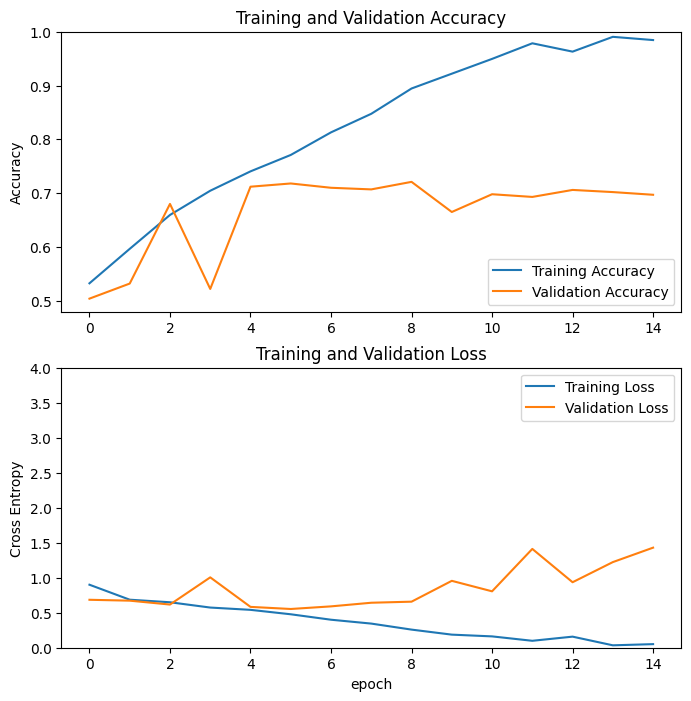

In [21]:
def plot_accuracy_and_loss(history):

  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,4.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

plot_accuracy_and_loss(history)

## Data Augmentation by using ImageDataGenerator

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 160x160 and their labels (sparse).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [22]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
# TODO 4 use flow_from_directory to generate a train_generator
train_generator = train_datagen.flow_from_directory(
    train_dir,  # train directory path
    target_size=(160, 160),
    batch_size=32,
    class_mode='sparse'
)

# Flow validation images in batches of 32 using val_datagen generator
# TODO 5 use flow_from_directory to generate a validation_generator
validation_generator = val_datagen.flow_from_directory(
    validation_dir,  # validation directory path
    target_size=(160, 160),
    batch_size=32,
    class_mode='sparse'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training
Let's train on all 2,000 images available, for 15 epochs, and validate on all 1,000 validation images. (This may take a few minutes to run.)

In [23]:
# Entrenar el modelo utilizando train_generator y validation_generator durante 40 épocas.
history = cnn.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

/Users/leonardodulcetti/Desktop/Notebook UAX/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - acc: 0.4996 - loss: 0.9177 - val_acc: 0.4980 - val_loss: 0.7088
Epoch 2/40
 1/62 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.5625 - loss: 0.6863

/Users/leonardodulcetti/Desktop/Notebook UAX/venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.5625 - loss: 0.6863 - val_acc: 0.4990 - val_loss: 0.7017
Epoch 3/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - acc: 0.4906 - loss: 0.7068 - val_acc: 0.5010 - val_loss: 0.6960
Epoch 4/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.6250 - loss: 0.6768 - val_acc: 0.5010 - val_loss: 0.7080
Epoch 5/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - acc: 0.5158 - loss: 0.7038 - val_acc: 0.4990 - val_loss: 0.6981
Epoch 6/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.5000 - loss: 0.6978 - val_acc: 0.5030 - val_loss: 0.6946
Epoch 7/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - acc: 0.5061 - loss: 0.6978 - val_acc: 0.5010 - val_loss: 0.6937
Epoch 8/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.4375 - loss: 0.6980 - val_acc: 0.5000 - val_loss: 0.6932
Epoch 9/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - acc: 0.5108 - loss: 0.6935 - val_acc: 0.4990 - val_loss: 0.6934
Epoch 10/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.5000 - los

## Metricas de ERROR: ACCURACY

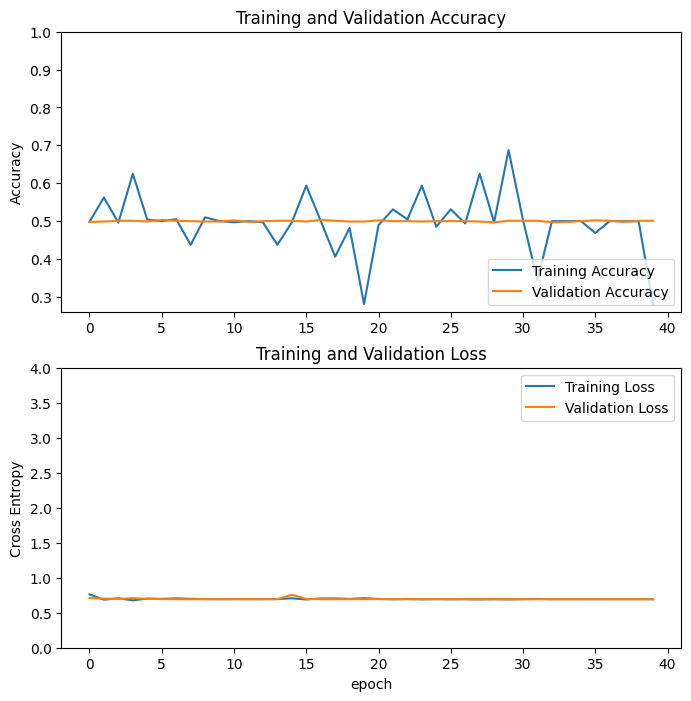

In [24]:
plot_accuracy_and_loss(history)

### Visualización de Representaciones Intermedias

Para comprender mejor qué tipo de características ha aprendido nuestra red convolucional, una forma interesante de hacerlo es visualizar cómo se transforma una imagen de entrada a medida que pasa por la red.

Seleccionaremos una imagen aleatoria de gato o perro del conjunto de entrenamiento y generaremos una figura donde:

- Cada fila representa la salida de una capa de la red. (Each row is the output of a layer)

- Cada imagen en la fila corresponde a un filtro específico dentro del mapa de características de salida.

Vuelve a ejecutar esta celda para generar representaciones intermedias de diferentes imágenes de entrenamiento.

['rescaling', 'conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'flatten', 'dense', 'dense_1']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


/var/folders/4w/82dzb8xs1nj9dz11ykfwbql80000gn/T/ipykernel_40059/85700552.py:47: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
/var/folders/4w/82dzb8xs1nj9dz11ykfwbql80000gn/T/ipykernel_40059/85700552.py:50: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


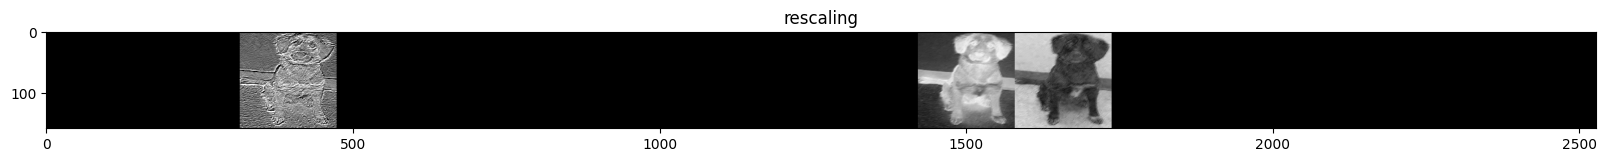

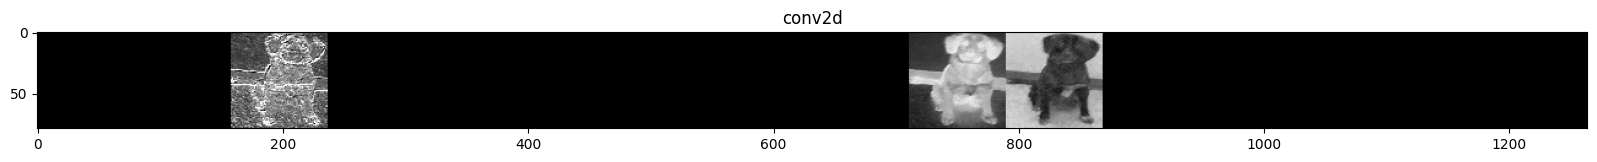

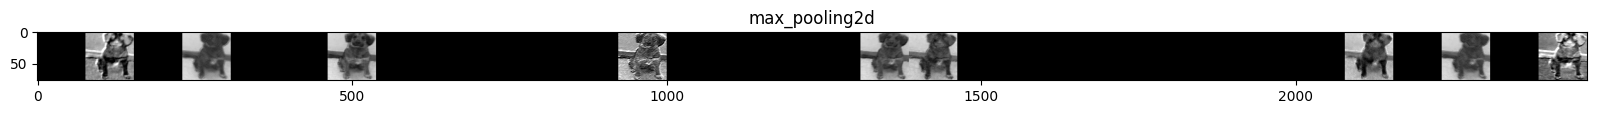

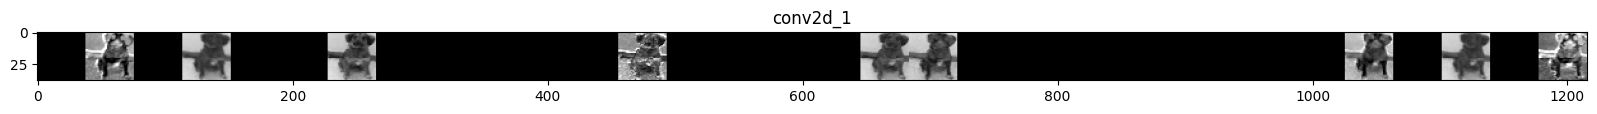

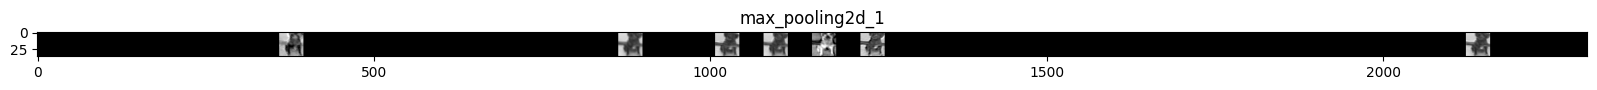

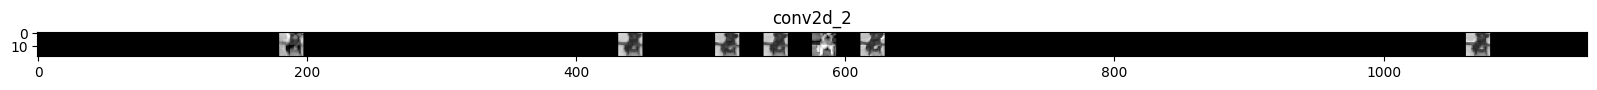

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import Model

# Definamos un nuevo modelo que tomará una imagen como entrada y generará las representaciones intermedias 
# de todas las capas del modelo anterior, después de la primera.
layer_names = [layer.name for layer in cnn.layers]
print(layer_names)
successive_outputs = [layer.output for layer in cnn.layers[1:]]  
visualization_model = Model(inputs=cnn.layers[0].input, outputs=successive_outputs)


# Preparemos una imagen de entrada aleatoria de un gato o perro del conjunto de entrenamiento.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(160, 160))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (160, 160, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (160, 160, 160, 3)

# Reescalar la imagen dividiendo por 255 para normalizar los valores de píxeles en el rango [0,1].
x /= 255

# Ejecutemos nuestra imagen a través de la red para obtener todas las representaciones intermedias de esta imagen.
successive_feature_maps = visualization_model.predict(x)

# Estos son los nombres de las capas, por lo que podemos incluirlos en nuestro gráfico.
layer_names = [layer.name for layer in cnn.layers]

# Ahora, mostremos nuestras representaciones.
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Haz esto solo para las capas de convolución y max-pooling, excluyendo las capas completamente conectadas (fully-connected).
    n_features = feature_map.shape[-1]  # number of features in feature map
    # El mapa de características tiene la forma (1, tamaño, tamaño, n_features), donde 1 : Representa el lote único de la imagen de entrada.
    # tamaño × tamaño: Representa las dimensiones espaciales del mapa de características.
    # n_features: Representa el número de filtros en esa capa.
    size = feature_map.shape[1]
    # Organizaremos nuestras imágenes en una matriz en mosaico (tile) para visualizarlas de manera clara.
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Posprocesaremos las características para hacerlas visualmente más comprensibles.
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # Organizaremos cada filtro en una gran cuadrícula horizontal. (Grid)
      display_grid[:, i * size : (i + 1) * size] = x
    # Visualización
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')

Como podéis ver, pasamos de los píxeles crudos de las imágenes a representaciones cada vez más abstractas y compactas.

Las representaciones en capas más profundas comienzan a resaltar en qué presta atención la red. 

 - Cada vez menos características son "activadas", con muchas establecidas en cero. Esto se conoce como "esparsidad" (sparsity). La esparsidad de representación es una característica clave del aprendizaje profundo.


A medida que avanzamos, estas representaciones contienen menos información sobre los píxeles originales, pero más información refinada sobre la clase de la imagen.

Puedes pensar en una red convolucional (o en una red profunda en general) como un proceso de destilación de información.